In [2]:
from FeedForwardNN import Feedforward

from Toy_Datasets import two_clusters_gaussian, plot_decision_boundary
from Neural_Network import NLM,Classifier
import autograd.numpy as np
from sklearn.linear_model import LogisticRegression
from autograd import grad
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc
from sklearn.model_selection import train_test_split
from pandas import get_dummies

In [3]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

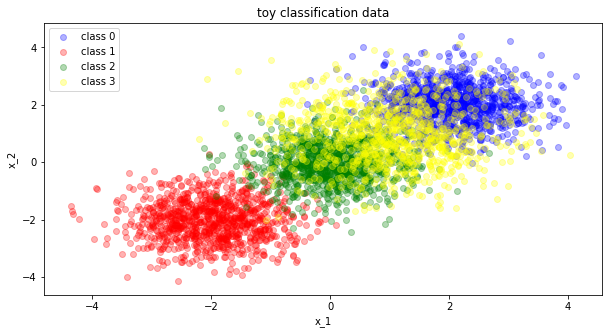

In [4]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params_4 = {'mean': [1, 1], 'covariance_matrix': 1 * np.eye(2)}

params = [params_1, params_2,params_3,params_4]
x, y = two_clusters_gaussian(params, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')
ax.scatter(x[y == 3, 0], x[y == 3, 1], alpha=0.3, color='yellow', label='class 3')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

# test BNN
* 4 classes
* output dim = 4
* batch = 200

In [20]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [21]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nn.fit(X_train.T, y_train.T, params)

#print(y_)
#X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
#nlm.fit_MLE(X_train.T, y_train.T, params)

ValueError: shapes (1,4,3200) and (12800,) not aligned: 3200 (dim 2) != 12800 (dim 0)

In [ ]:
#print(nn.forward(nn.weights,x.T)[0][0][:100],'\n')
#print(nn.forward(nn.weights,x.T)[0][0][100:200],'\n')
#print(nn.forward(nn.weights,x.T)[0][0][200:],'\n')
print(nn.forward(nn.weights,x.T))

In [ ]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    #print(constant)
    exponential = (-0.5 * sigma_y**-2 * np.sum((y.reshape((1, D_bayes)).T - (nn.forward(W, x.T)))**2, axis=1).flatten()).mean()
    #print(exponential)
    return constant + exponential

q=hmc(log_prior, log_likelihood, **params_hmc)

#log_likelihood(nn.weights)


In [13]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def HMC_Unit_test():
    # Generate a toy dataset for classification
    samples = 100
    class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
    class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
    x = np.vstack((class_0, class_1))
    y = np.array([0] * 100 + [1] * 100)
    mean = np.zeros(3)
    cov = 10*np.eye(3)
    D = 3

    def log_likelihood(w):
        theta = sigmoid(w[-1] + np.dot(x, w[:-1]))
        return np.sum(np.log(theta[y==1])) + np.sum(np.log(1 - theta[y==0]))

    def log_normal_prior(W):
        logprior = -0.5 * (np.log(np.linalg.det(cov)) + D * np.log(2 * np.pi))
        logprior += -0.5 * np.dot(np.dot(W-mean, np.linalg.inv(cov)), (W-mean).T)
        return logprior
    
    log_prior = log_normal_prior
    log_likelihood = log_likelihood
    lr = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    lr.fit(x, y)
    position_init = np.hstack((lr.coef_.flatten(), lr.intercept_))
    position_init = position_init.reshape((1, 3))[0]
    samples = hmc(log_prior, log_likelihood, 1000,  1e-1, 20, position_init, 0.1, 1)
    q_=np.asarray(samples).T
    plt.plot(range(len(q_[0])),q_[0] , color='r')
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(q_[0], lags=50)
    plt.show()
    #print(log_likelihood(position_init))
    return samples


100 : 0.69
200 : 0.68
300 : 0.6933333333333334
400 : 0.685
500 : 0.674
600 : 0.675
700 : 0.67
800 : 0.665
900 : 0.6688888888888889


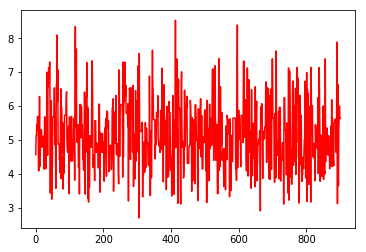

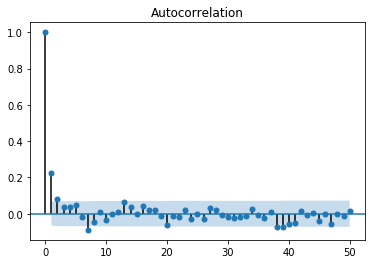

In [14]:
samples=HMC_Unit_test()

Text(0.5, 1.0, 'toy classification data with test data points and the linear boundary decision outputted by the posterior distribution for parameters')

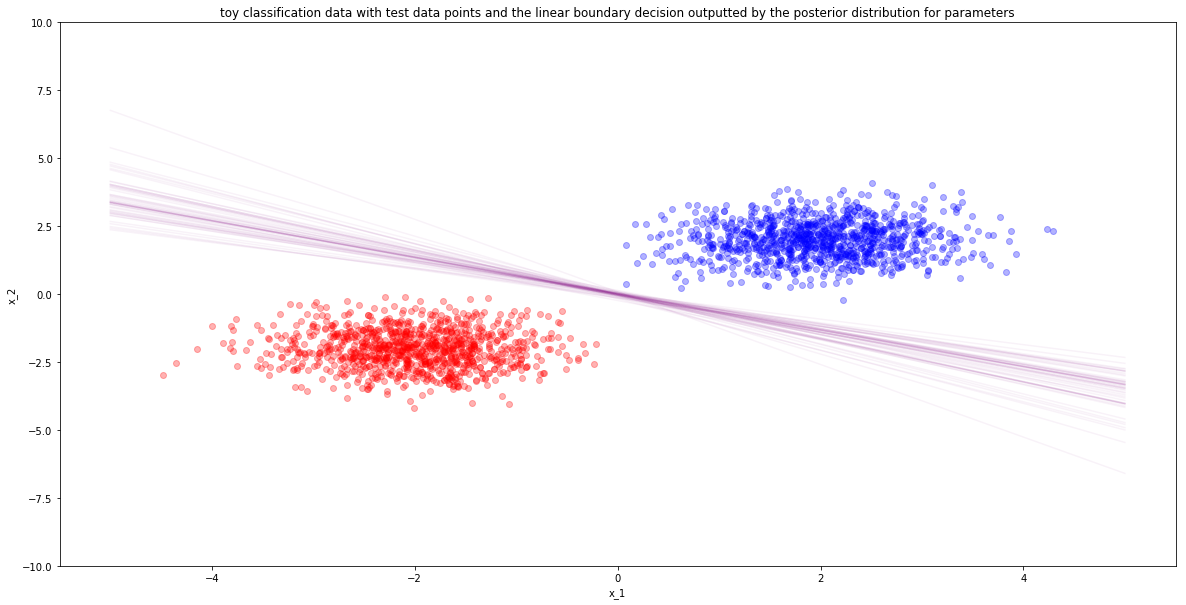

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for sample in samples:
    slope = lambda x :  -sample[1]/sample[0]*x - sample[2]/sample[0]
    if np.random.uniform()< 0.05:
        ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', alpha=0.05)
ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', label='Linear Boundary', alpha=0.2)
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')

#for i in range(len(test_points)):
#    pt = test_points[i]
#    if i == 0:
#        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#    else:
        #ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_ylim(-10, 10)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points and the linear boundary decision outputted by the posterior distribution for parameters')


# NLM

In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)

In [6]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)


y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nlm.fit_MLE(X_train.T, y_train.T, params)

Iteration 0 lower bound 1.7499219679454432; gradient mag: 1.9193615536726423
Iteration 100 lower bound 1.5290049352197996; gradient mag: 0.47581633062254775
Iteration 200 lower bound 1.24370781239939; gradient mag: 0.42413570047209515
Iteration 300 lower bound 0.922199938438283; gradient mag: 0.44439376006992
Iteration 400 lower bound 0.688971670992161; gradient mag: 0.2823029067743702
Iteration 500 lower bound 0.589089242314046; gradient mag: 0.2050486547047333
Iteration 600 lower bound 0.5242927436527849; gradient mag: 0.15990621112218106
Iteration 700 lower bound 0.4854329566107839; gradient mag: 0.10871308121768669
Iteration 800 lower bound 0.46709646897887686; gradient mag: 0.06779617023261811
Iteration 900 lower bound 0.4582639408871927; gradient mag: 0.04138631878677319
Iteration 1000 lower bound 0.4529009456578368; gradient mag: 0.030104289289752673
Iteration 1100 lower bound 0.4494546255486525; gradient mag: 0.02247233529604625
Iteration 1200 lower bound 0.4467250775899248; gr

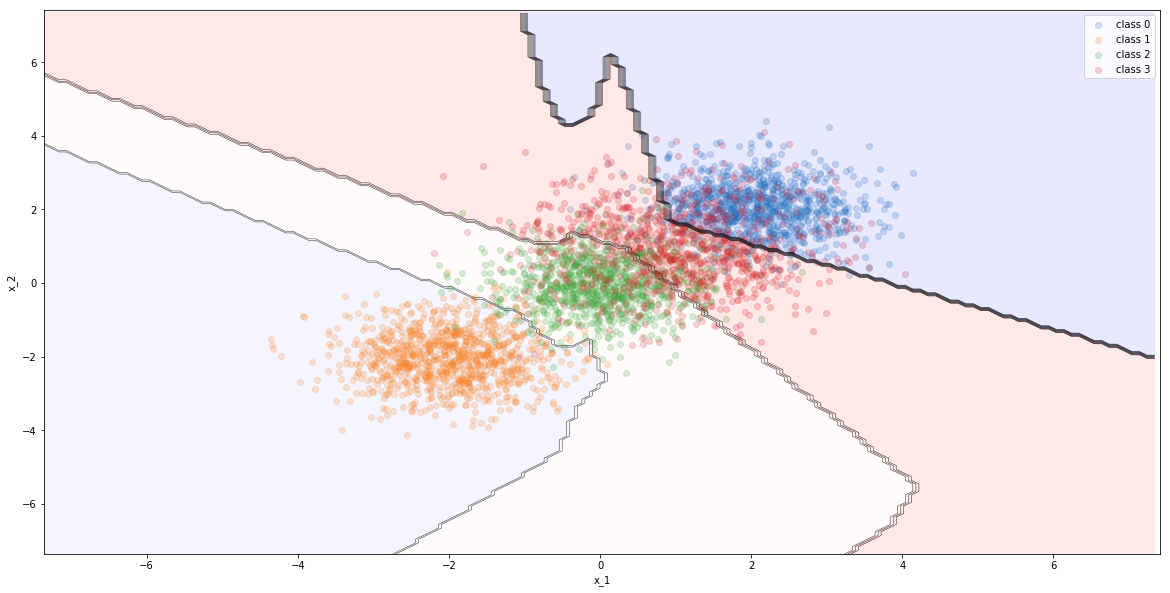

In [7]:
classifier = [Classifier(nlm.weights, nlm.forward)]
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y_, classifier, ax)
plt.show()

In [8]:
import theano.tensor as T
import autograd.numpy as np
from scipy.special import softmax
# def pymc3_sampling(D, out_last_hidden_layer, output_dim, out_y):
#     """
#     INPUTS:
#     D: dimension of the last hidden layer
#     sigma_in: std of the prior (a normal, with mean 0)
#
#     OUTPUTS:
#     """
#     with pm.Model() as replacing_HMC:
#         # w has a prior: N(0,1)
#         # Output dim number of bias
#         w = pm.Normal('w', mu=0, tau=1, shape=(D*output_dim+output_dim))
#         linear_combinations=[]
#         for j in range(output_dim):
#             dot=pm.math.dot(out_last_hidden_layer[0].T,w[j*D:j*D+D])+w[-j]
#             print(dot,j)
#             linear_combi = pm.Deterministic('s'+str(j),dot)
#             linear_combinations.append(linear_combi)
#         thetas = pm.Deterministic('theta', T.nnet.softmax(linear_combinations))
#         # or thetas = pm.Deterministic('theta', pm.math.softmax(linear_combi))?
#         # Y commes from a Categorical(thetas)
#         y_obs = pm.Bernoulli('y_obs', p=thetas, observed=out_y)
#         trace = pm.sample(1000,chains=2)
#     return trace

In [15]:
from pymc3 import Model
import pymc3 as pm
#!pip freeze
#from scipy._lib._util import _asarray_validated

#from scipy.special import softmax

traces=nlm.pymc3_sampling(5, nlm.forward(nlm.weights,X_train.T,partial=True), 4, y_train.T)

ValueError: operands could not be broadcast together with shapes (4,3200) (1,5,3200) 

In [ ]:
y_train.shape

In [ ]:
X_train.shape

In [ ]:
w_0=[]
w_1=[]
w_2=[]
for i in range(len(traces['w'])):    
    w_0.append(traces['w'][i][0])        
    w_1.append(traces['w'][i][1])        
    w_2.append(traces['w'][i][2])
    
fig, ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(range(len(w_0)), w_0, color='b')
ax.set_title('Trace plot')

In [11]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nlm.weights,
       'burn':.1, 
       'thin':2,}

#sigmoid_probability=nlm.forward(nlm.weights, x.T)
#sigmoid_probability = np.clip(sigmoid_probability, 1e-15, 1 - 1e-15)
#bce = np.dot(np.log(sigmoid_probability),y.flatten())
#bce1 = sum([np.dot(np.log(sigmoid_probability)[:,:,i],y.flatten()[i]) for i in range(len(y.flatten()))])
#-sum([p[i]*log2(q[i]) for i in range(len(p))])
#print(bce,'\n',bce1)


nlm.forward(nlm.weights,x.T).shape


(4000, 4)

In [14]:
#print(nlm.weights)
nlm.fit_NLM(X_train.T, y_train.T)


You can find the C code in this temporary file: /var/folders/72/7tyqmpr158x1ps3r1z7591pw0000gp/T/theano_compilation_error_xcm9_g6s


Exception: ("Compilation failed (return status=1): In file included from /Users/gaelancel/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.5.6-64/tmp00r8lq2d/mod.cpp:1:. In file included from /Users/gaelancel/anaconda3/include/python3.5m/Python.h:25:. /Users/gaelancel/anaconda3/bin/../include/c++/v1/stdio.h:108:15: fatal error: 'stdio.h' file not found. #include_next <stdio.h>.               ^~~~~~~~~. 1 error generated.. ", '[Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{1.0})]')